In [73]:
from astroquery.sdss import SDSS
import math
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from specutils.fitting import fit_generic_continuum
from specutils import Spectrum
from labellines import labelLines
import matplotlib.axes as axes
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import scipy

plt.rcParams['agg.path.chunksize'] = 120

In [75]:
plate = 4233
mjd = 55449
fiber = 623

#Get spectra from astroquery
sp = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiber)

spec_hdu = sp[0]
spec_data = spec_hdu[1].data #data with the fits

z = spec_hdu[2].data["z"]

#print out the headers
header = spec_hdu[0].header

#set parameters
loglam = spec_data['loglam']
uncert = 1/np.sqrt(spec_data['ivar'])
flux = spec_data['flux']
wavelength = 10**loglam
print(spec_hdu[1].columns)

ColDefs(
    name = 'flux'; format = 'E'
    name = 'loglam'; format = 'E'
    name = 'ivar'; format = 'E'
    name = 'and_mask'; format = 'J'
    name = 'or_mask'; format = 'J'
    name = 'wdisp'; format = 'E'
    name = 'sky'; format = 'E'
    name = 'model'; format = 'E'
)


C:\Users\nihad\AppData\Local\Temp\ipykernel_53696\3979808629.py:18: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:181: UserWarning: Tried to label line Line2D(_child6), but could not find a label for it.
  warnings.warn(
C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:267: UserWarning: The value at position 2 in `xvals` is outside the range of its associated line (xmin=4960.294999999999, xmax=4960.294999999999, xval=4960.295). Clipping it into the allowed range.
  warnings.warn(
C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:267: UserWarning: The value at position 3 in `xvals` is outside the range of its associated line (xmin=4862.679999999999, xmax=4862.679999999999, xval=4862.68). Clipping it into the allowed range.
  warnings.warn(
C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:267: UserWarning: The value at position 4 in `xvals` is outside the range of its associated line (xmin=4102.889999999999, xmax=4102.889999999999, xval=4102.89). Clipping it into the allowed range.
  warnings.warn(


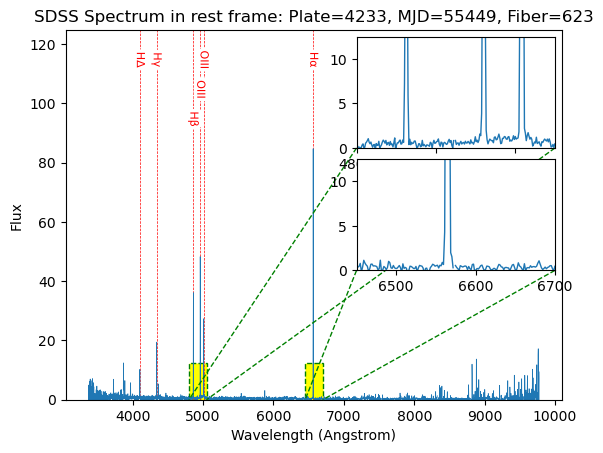

In [77]:
fig, ax = plt.subplots()

#common spectral lines in SDSS
xvals = [6564.61, 5008.240, 4960.295, 4862.68, 4102.89, 4341.68]
label = ['Hα', 'OIII', 'OIII', 'Hβ', 'HΔ', 'Hγ']

for i in range(len(xvals)):
     plt.axvline(xvals[i], color="red", linewidth=0.5, linestyle="--", label= label[i])

#plot the spectrum
ax.plot(wavelength/(1+z), flux, linewidth=0.5)
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
y_top = max(flux) + 40
plt.ylim(0,y_top)
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

#vertical lines
offset = [y_top/2-10, y_top/2-10, y_top/2-20, y_top/2-30, y_top/2-10, y_top/2-10]
lines = plt.gca().get_lines()
labelLines(lines, align=True, yoffsets=offset, xvals = xvals, fontsize = 8)

#inset plot
inset1 = inset_axes(ax, width='40%', height='30%', loc='upper right',)
inset1.plot(wavelength/(1+z), flux, linewidth=1)
inset1.set_xlim(4800, 5050)
inset1.set_ylim(0, y_top/10)
mark_inset(ax, inset1, loc1=3, loc2=4, fc='yellow', ec='g', ls='--')

#inset plot
inset2 = inset_axes(ax, width='40%', height='30%', loc='center right',)
inset2.plot(wavelength/(1+z), flux, linewidth=1)
inset2.set_xlim(6450, 6700)
inset2.set_ylim(0, y_top/10)
mark_inset(ax, inset2, loc1=3, loc2=4, fc='yellow', ec='g', ls='--')

plt.show()

In [79]:
def o_iii_1(x, amp, wid):
    return (3*amp * np.exp(-(x - 5008.240)**2 / (2 * wid**2)))
    
def o_iii_2(x, amp, wid):
    return (amp * np.exp(-(x - 4960.295)**2 / (2 * wid**2)))

def broad_1(x, amp, wid):
    return (3*amp * np.exp(-(x - 5008.240)**2 / (2 * (wid)**2)))

def broad_2(x, amp, wid):
    return (amp * np.exp(-(x - 4960.295)**2 / (2 * (wid)**2)))

def Gauss(x,amp1, amp2, wid1, wid2):
    return o_iii_1(x, amp1, wid1) + o_iii_2(x, amp1, wid1) + broad_1(x, amp2, wid2) + broad_2(x, amp2, wid2)

In [81]:
#Fitting the spectrum to a continuum using fit_generic_spectrum from Specutils
uerg = u.erg/(u.s*u.cm**2*u.AA)
spec1d = Spectrum(spectral_axis=wavelength/(1+z)*u.AA, flux=flux*uerg)
continuum=fit_generic_continuum(spec1d)
print(continuum)
fit_cont = continuum(wavelength/(1+z)*u.AA)

<QuantityModel Chebyshev1D(3, c0=-0.52343675, c1=0.00103301, c2=-0.00000011, c3=0.), input_units=Angstrom, return_units=erg / (Angstrom s cm2)>


[52.58658193  0.14460805  1.14149892  9.48508277]


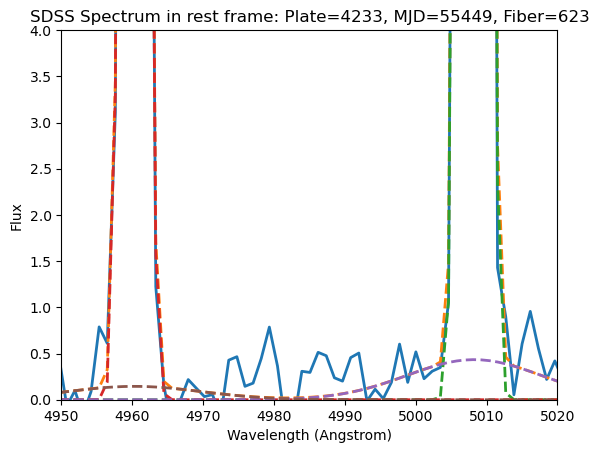

In [83]:
inf = math.inf
flux_normal = flux*uerg-fit_cont #normalized flux minus continuum

parameters, covariance = curve_fit(Gauss, wavelength/(1+z), flux_normal,sigma = uncert,  method = "trf", p0=[200, 2, 2, 10], 
                                   bounds=([0,0,0,5],[inf, 5,10, 500]))
print(parameters)
A, B, C, D= parameters
fit_y = Gauss(wavelength/(1+z), A, B, C, D)


#Plots the gaussian with the fits
plt.plot(wavelength/(1+z), flux_normal, linewidth=2, label='Data')
plt.plot(wavelength/(1+z), fit_y, '--',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), o_iii_1(wavelength/(1+z), A, C), '--',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), o_iii_2(wavelength/(1+z), A, C), '--',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), broad_1(wavelength/(1+z), B, D), '--',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), broad_2(wavelength/(1+z), B, D), '--',linewidth=2, label='Fit')

#ranges for x and y to show
plt.xlim(4950, 5020)
plt.ylim(0,4)

#labels
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

#save the fit file
plt.savefig("Gaussian_fit_length.png")
plt.show()

In [85]:
c = 3*10**5 #km/s
inf = math.inf

def o_iii_1(x, amp, sig, v):
    x_0 = 5008.240* (1+(v/c))
    wid= sig*x_0/c
    return (3*amp * np.exp(-(x - x_0)**2 / (2 * wid**2)))
    
def o_iii_2(x, amp, sig, v):
    x_0 = 4960.295 * (1+(v/c))
    wid= sig*x_0/c
    return (amp * np.exp(-(x - x_0)**2 / (2 * wid**2)))

def broad_1(x, amp, sig, v):
    x_0 = 5008.240* (1+(v/c))
    wid= sig*x_0/c
    return (3*amp * np.exp(-(x - x_0)**2 / (2 * (wid)**2)))

def broad_2(x, amp, sig, v):
    x_0 = 4960.295 * (1+(v/c))
    wid= sig*x_0/c
    return (amp * np.exp(-(x - x_0)**2 / (2 * (wid)**2)))

def Gauss(x,amp1, amp2, sig1, sig2, v_n, v_b):
    return o_iii_1(x, amp1, sig1, v_n) + o_iii_2(x, amp1, sig1, v_n) + broad_1(x, amp2, sig2, v_b) + broad_2(x, amp2, sig2, v_b)

[5.27652291e+01 1.44139933e-01 6.85080108e+01 5.69884092e+02
 4.14362648e-12 5.74376039e-19]


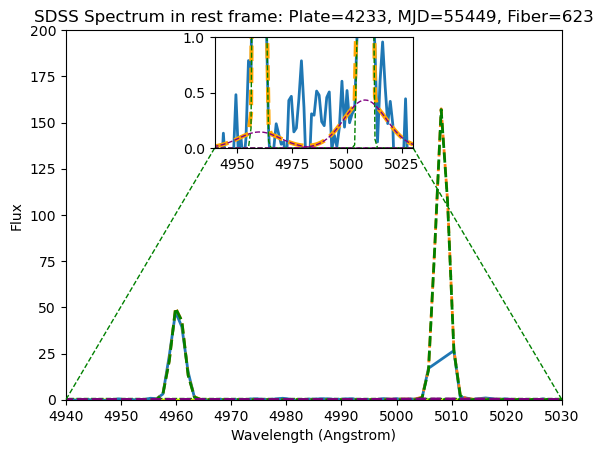

In [89]:
inf = math.inf
flux_normal = flux-fit_cont/uerg #normalized flux minus continuum

parameters, covariance = curve_fit(Gauss, wavelength/(1+z), flux_normal,sigma = uncert,  method = "trf", p0=[200, 2, 50, 1000, 50, 50], 
                                   bounds=([0,0,50,500,0,0],[inf,5,500, 5000,inf,inf]))
print(parameters)
A, B, C, D, E, F= parameters
fit_y = Gauss(wavelength/(1+z), A, B, C, D, E, F)


#Plots the gaussian with the fits
fig, ax = plt.subplots()
plt.plot(wavelength/(1+z), flux_normal, linewidth=2, label='Data')
plt.plot(wavelength/(1+z), fit_y, '--',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), o_iii_1(wavelength/(1+z), A, C, E), '--',color = 'green',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), o_iii_2(wavelength/(1+z), A, C, E), '--',color = 'green',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), broad_1(wavelength/(1+z), B, D, F), '--',color = 'purple',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), broad_2(wavelength/(1+z), B, D, F), '--',color = 'purple',linewidth=2, label='Fit')

#ranges for x and y to show
plt.xlim(4940, 5030)
plt.ylim(0,200)

#labels
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

inset = inset_axes(ax, width='40%', height='30%', loc='upper center',)
inset.plot(wavelength/(1+z), flux_normal, linewidth=2, label='Data')
inset.plot(wavelength/(1+z), fit_y, '--', color = 'orange',linewidth=3)
inset.plot(wavelength/(1+z), o_iii_1(wavelength/(1+z), A, C, E), '--',color = 'green',linewidth=1, label='Fit')
inset.plot(wavelength/(1+z), o_iii_2(wavelength/(1+z), A, C, E), '--',color = 'green',linewidth=1, label='Fit')
inset.plot(wavelength/(1+z), broad_1(wavelength/(1+z), B, D, F), '--',color = 'purple',linewidth=1, label='Fit')
inset.plot(wavelength/(1+z), broad_2(wavelength/(1+z), B, D, F), '--',color = 'purple',linewidth=1, label='Fit')
inset.set_xlim(4940, 5030)
inset.set_ylim(0, 1)
mark_inset(ax, inset, loc1=3, loc2=4, fc='yellow', ec='g', ls='--')

#save the fit file
plt.savefig("Gaussian_fit_time.png")
plt.show()

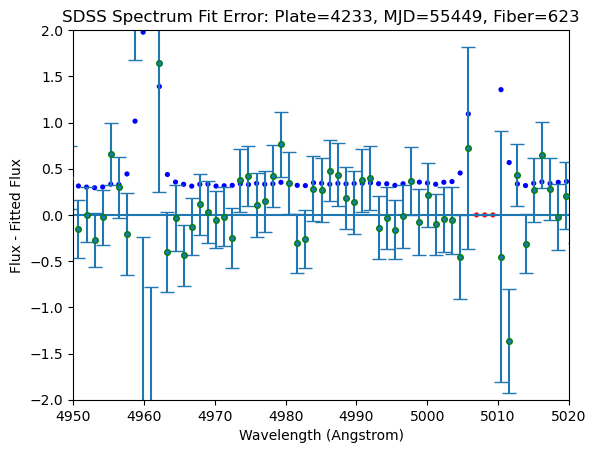

In [91]:
err = flux_normal-fit_y
infty = []
color = []
uncert = [(1/np.sqrt(item)) if (item != 0) else 0 for item in spec_data['ivar']]
color = ['blue' if (item != 0) else 'red' for item in spec_data['ivar']]
plt.errorbar(wavelength/(1+z), err, yerr = uncert, fmt='o',markersize=4, zorder=2.5, capsize=5, markeredgecolor="green", label='Data')
plt.scatter(wavelength/(1+z), uncert, color = color, linewidth=2, s = 3, label='Data')
plt.axhline(y = 0)
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux - Fitted Flux")
plt.title(f"SDSS Spectrum Fit Error: Plate={plate}, MJD={mjd}, Fiber={fiber}")
plt.xlim(4950, 5020)
plt.ylim(-2, 2)
plt.savefig("Gaussian_fit_residuals.png")

plt.show()